In [1]:
import keras

from keras import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

from keras.layers import Flatten

from keras.layers import Reshape

from keras.layers import Activation

from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.optimizers import RMSprop

from keras.regularizers import l2

import keras.backend as K

import numpy as np
import pandas as pd
import os
from scipy import signal

from sklearn.cross_validation import train_test_split

I:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
I:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
train_data = []
train_labels = []

val_data = []
val_labels = []


sample = 128 #hz
trial_time = 3 #s

origin_channel = 5 #5 channel eeg

keep_prob = 0.5 #dropout

In [10]:
def load_data(path = 'raw_eeg/'):
    data = []
    
    #file_names = [name for name in os.listdir(path) if name.endswith('csv')]
    
    #指定颜色
    file_names = ['pink.csv' , 'white.csv' , 'yellow.csv']
    
    for file_name in file_names:
        temp = pd.read_csv(path + file_name)
        
        #删除前3秒和后2秒数据
        temp = temp.iloc[ : temp.shape[0] - 2*128] #后2秒 2s sample:128hz
        temp = temp.iloc[3*128 : ] #前3秒 3s sample:128hz
        #5 channels data
        data.append(temp[['AF3' , 'T7','Pz' , 'T8' , 'AF4']])
    
    return data

In [11]:
#窗口为384（3s*128hz）步长为暂定为1

#window_stride = 1

def sep(one_data , label):
    size = sample*trial_time #384
    
    for i in range(one_data.shape[0] - size):
        train_data.append(one_data.iloc[i : i+size].values) #add one train sample
        train_labels.append(label) #corresponding label

In [12]:
#load 训练数据
data = load_data(path = 'test_raw_eeg/test_color2/')

#=========
for i in range(3):
    for column in data[i].columns:
        #data[i][column] = bandpass_filter(data[i][column])
        data[i][column] = (data[i][column] - data[i][column].mean())/data[i][column].std() #norm

#=========

for i in range(3):
    sep(data[i] , i)

In [13]:
train_labels = keras.utils.to_categorical(train_labels , 3) #one-hot
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [14]:
print(train_data.shape , train_labels.shape)

(15032, 384, 5) (15032, 3)


In [15]:
#==========
#带通滤波器
#暂时没用
'''
def bandpass_filter(series):
    low_feq = 0.5
    high_feq = 100
    
    b  , a = signal.butter(2 , low_feq / sample , btype='low')
    
    series = signal.filtfilt(b , a , series)
    
    b  , a = signal.butter(2 , high_feq / sample , btype='high')

    series = signal.filtfilt(b , a , series)
    
    return series
'''
#===========
#===========

In [6]:
#===============
#===============
#validation data

In [16]:
#window_stride = 1

def sep_val(one_data , label):
    size = sample*trial_time #384
    
    for i in range(one_data.shape[0] - size):
        val_data.append(one_data.iloc[i : i+size].values) #add one train sample
        val_labels.append(label) #corresponding label

In [17]:
#load 验证数据
data_val = load_data(path = 'test_raw_eeg/test_color1/')

#=========
for i in range(3):
    for column in data_val[i].columns:
        #data_val[i][column] = bandpass_filter(data_val[i][column])
        data_val[i][column] = (data_val[i][column] - data_val[i][column].mean()) / data_val[i][column].std() #norm
#=========

for i in range(3):
    sep_val(data_val[i] , i)

In [18]:
val_labels = keras.utils.to_categorical(val_labels , 3)
val_data = np.array(val_data)
val_labels = np.array(val_labels)
#===============
#===============
print(val_data.shape , val_labels.shape)

(12264, 384, 5)


In [19]:
val_labels.shape

(12264, 3)

In [13]:
#=============
#=============
#pass filter
#low 0.5hz
#high 100hz

In [21]:
#搭建模型
model = Sequential()

#CNNs需要的训练样本集的形式为 （样本数量，384,5） 384为单个样本长度 5为单个样本的通道数量

#fc
model.add(Dense(units=30 , input_shape=(sample*trial_time , origin_channel) , activation='elu' , kernel_regularizer=l2()))
model.add(Reshape((30 , sample*trial_time , 1)))

#conv pool 1
model.add(Conv2D(60 , kernel_size=(1,15) , strides=(1,3) , padding='valid' , activation='elu' , kernel_regularizer=l2()))
model.add(MaxPooling2D(pool_size=(1,2) , strides=(1,2) , padding='valid'))
#dropout
model.add(Dropout(1 - keep_prob))
#batch norm
model.add(BatchNormalization())

#conv pool 2
model.add(Conv2D(60 , kernel_size=(1,4) , strides=(1,3) , padding='valid' , activation='elu' , kernel_regularizer=l2()))
model.add(MaxPooling2D(pool_size=(1,2) , strides=(1,2) , padding='valid'))
#dropout
model.add(Dropout(1 - keep_prob))
#batch norm
model.add(BatchNormalization())

#conv 3
model.add(Conv2D(60 , kernel_size=(30,1) , strides=(1,3) , padding='valid' , activation='elu' , kernel_regularizer=l2()))
#dropout
model.add(Dropout(1 - keep_prob))
#batch norm
model.add(BatchNormalization())

#conv pool 4
model.add(Conv2D(90 , kernel_size=(1,3) , strides=(1,1) , padding='same' , activation='elu' , kernel_regularizer=l2()))
model.add(MaxPooling2D(pool_size=(1,2) , strides=(1,2) , padding='valid'))
#dropout
model.add(Dropout(1 - keep_prob))
#batch norm
model.add(BatchNormalization())

#conv pool 5
model.add(Conv2D(120 , kernel_size=(1,3) , strides=(1,1) , padding='same' , activation='elu' , kernel_regularizer=l2()))
model.add(MaxPooling2D(pool_size=(1,2) , strides=(1,2) , padding='valid'))
#dropout
model.add(Dropout(1 - keep_prob))
#batch norm
model.add(BatchNormalization())

#flatten
model.add(Flatten())

#fc
model.add(Dense(units=24 , activation='elu' , kernel_regularizer=l2()))

#extra for cluster layer
model.add(Dense(units=12 , activation='elu' , kernel_regularizer=l2() , name = 'feature1'))
model.add(Dense(units=4 , activation='elu' , kernel_regularizer=l2() , name = 'feature2'))
model.add(Dense(units=2 ,  activation='elu' , kernel_regularizer=l2() , name = 'feature3'))

#fc last layer
model.add(Dense(units=3 , activation='softmax'))

In [2]:
model.summary()

NameError: name 'model' is not defined

In [107]:
#=========
#合并全部样本 cluster
all_data = np.concatenate((train_data , val_data))
all_labels = np.concatenate((train_labels , val_labels))

#=========

In [83]:
rmsprop = RMSprop()
epochs = 300
batch_size = 16

In [24]:
model.compile(optimizer=rmsprop ,
              loss = 'categorical_crossentropy' ,
              metrics=['accuracy'])

In [1]:
model.fit(all_data , all_labels , batch_size=batch_size , epochs=epochs , shuffle=True)# , validation_data = (val_data , val_labels))

NameError: name 'model' is not defined

In [110]:
model.evaluate(train_data , train_labels , batch_size=batch_size)
#输出结果为损失 和 准确率

40/40 [==============================] - 0s 11ms/step


[0.3653468549251556, 1.0]

In [65]:
#提取中间层输出结果 构造模型
from keras.models import Model

get_feature3_model = Model(input = model.input , output = model.get_layer('feature3').output)

I:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("de..., outputs=Tensor("fe...)`


In [86]:
#中间层输出结果（特征抽取 feature3层） train data
new_train_feature3 = get_feature3_model.predict(train_data)

train_labels_label = train_labels.argmax(axis=1)

In [87]:
#中间层 （特征抽取） val data
new_val_feature3 = get_feature3_model.predict(val_data)

val_labels_label = val_labels.argmax(axis=1)

In [112]:
#中间层 （特征抽取） all data
new_all_feature3 = get_feature3_model.predict(all_data)

all_labels_label = all_labels.argmax(axis=1)

In [36]:
from sklearn.cluster import KMeans

In [88]:
#3 colors
kmeans = KMeans(n_clusters=3)

kmeans.fit(new_train_feature3 , train_labels_label)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [89]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2])

In [90]:
train_labels_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [77]:
#聚类结果可视化
import matplotlib.pyplot as plt
%matplotlib inline

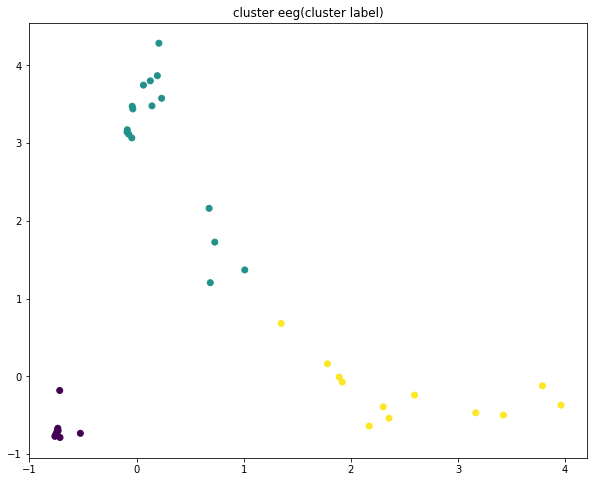

In [91]:
plt.figure(figsize=(10 , 8))
plt.scatter(new_train_feature3[: , 0] , new_train_feature3[: , 1]  , c = kmeans.labels_)
plt.title('cluster eeg(cluster label)')

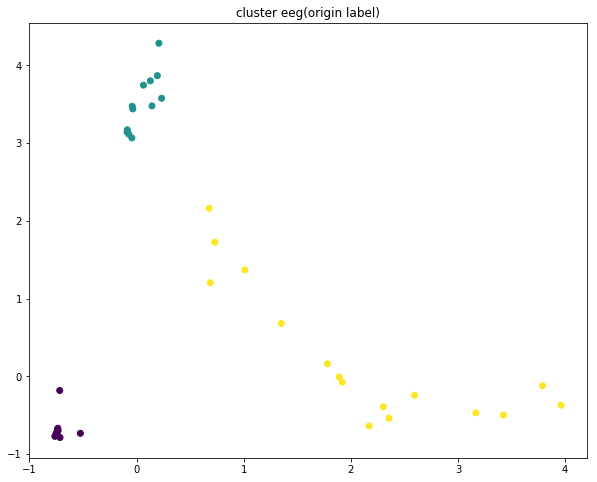

In [92]:
plt.figure(figsize=(10 , 8))
plt.scatter(new_train_feature3[: , 0] , new_train_feature3[: , 1]  , c = train_labels_label)
plt.title('cluster eeg(origin label)')

In [93]:
kmeans_val = KMeans(n_clusters=3)

kmeans_val.fit(new_val_feature3 , val_labels_label)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [94]:
kmeans_val.labels_

array([1, 1, 1, 2, 0, 1, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [95]:
val_labels_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

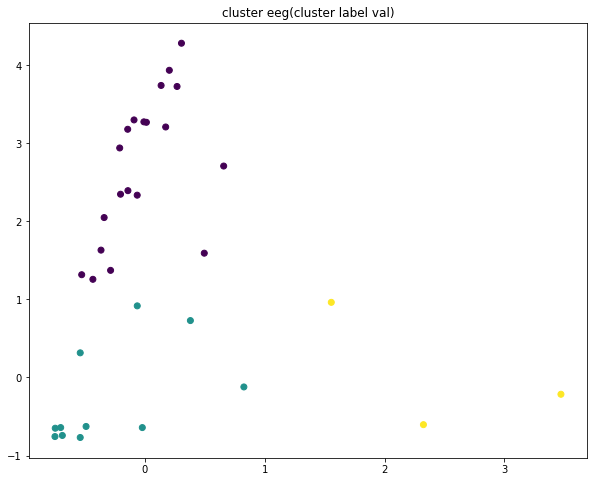

In [96]:
plt.figure(figsize=(10 , 8))
plt.scatter(new_val_feature3[: , 0] , new_val_feature3[: , 1]  , c = kmeans_val.labels_)
plt.title('cluster eeg(cluster label val)')

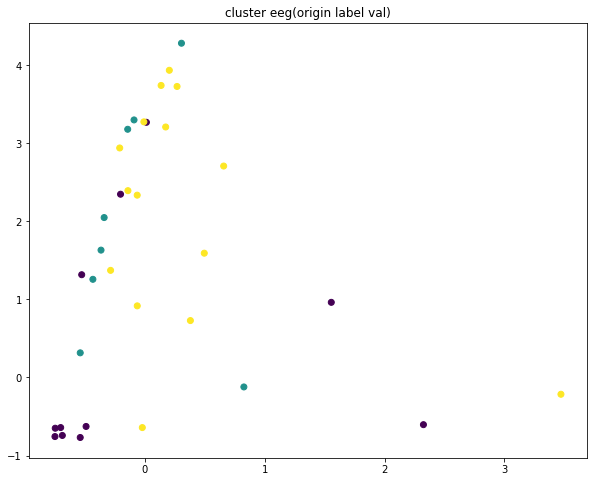

In [97]:
plt.figure(figsize=(10 , 8))
plt.scatter(new_val_feature3[: , 0] , new_val_feature3[: , 1]  , c = val_labels_label)
plt.title('cluster eeg(origin label val)')

In [113]:
kmeans_all = KMeans(n_clusters=3)

kmeans_all.fit(new_all_feature3 , all_labels_label)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [116]:
kmeans_all.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [117]:
all_labels_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

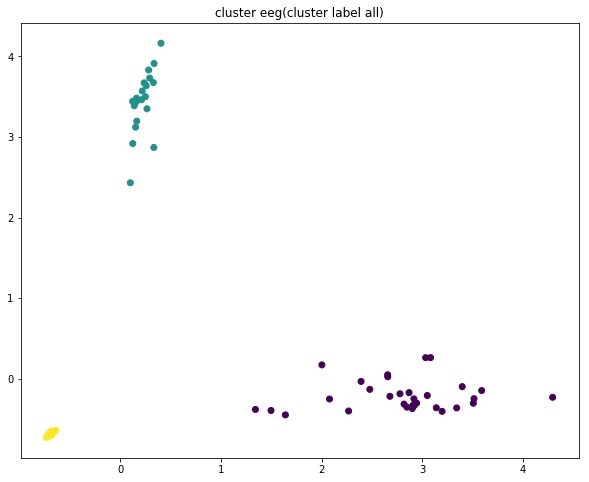

In [114]:
plt.figure(figsize=(10 , 8))
plt.scatter(new_all_feature3[: , 0] , new_all_feature3[: , 1]  , c = kmeans_all.labels_)
plt.title('cluster eeg(cluster label all)')

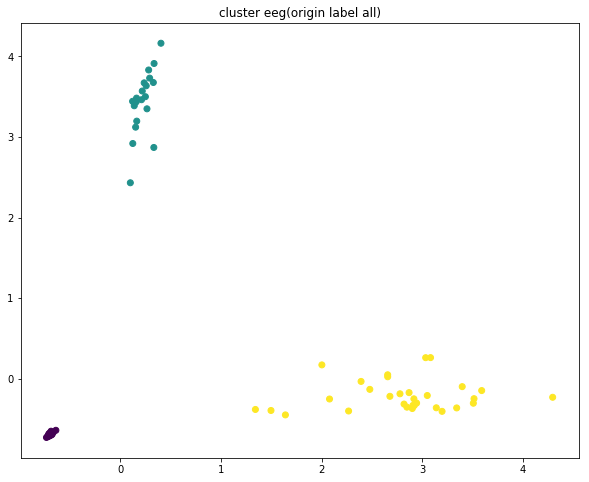

In [115]:
plt.figure(figsize=(10 , 8))
plt.scatter(new_all_feature3[: , 0] , new_all_feature3[: , 1]  , c = all_labels_label)
plt.title('cluster eeg(origin label all)')

In [49]:
from sklearn.svm import SVC

In [80]:
svc = SVC()

svc.fit(new_train_feature3 , train_labels_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [81]:
svc.score(new_train_feature3 , train_labels_label)

1.0

In [82]:
svc.score(new_val_feature3 , val_labels_label)

0.5